# Self Case Study-1_Pump it up-Data Mining the Water Table

## Section-II

## 4. Feature Engineering and Baseline model

#### 4.1 Importing required libraries & reading data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  
import re
import time
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from nltk.corpus import stopwords
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
import sys
from category_encoders import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from category_encoders import TargetEncoder, LeaveOneOutEncoder, WOEEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import confusion_matrix

In [2]:
import pandas as pd

In [3]:
df1 = pd.read_csv('data/clean_df.csv')

In [4]:
df1.head()

,Unnamed: 0,id,amount_tsh,funder,gps_height,installer,longitude,latitude,basin,region,...,permit,extraction_type_group,management,payment,water_quality,quantity,source,status_group,operational_year,waterpoint_type
0,0,69572,6000.0,other,1390,other,34.938093,-9.856322,Lake Nyasa,Iringa,...,False,gravity,vwc,pay annually,soft,enough,spring,functional,12,communal standpipe
1,1,8776,0.0,other,1399,other,34.698766,-2.147466,Lake Victoria,Mara,...,True,gravity,wug,never pay,soft,insufficient,rainwater harvesting,functional,3,communal standpipe
2,2,34310,25.0,other,686,World Vision,37.460664,-3.821329,Pangani,Manyara,...,True,gravity,vwc,pay per bucket,soft,enough,dam,functional,4,communal standpipe multiple
3,3,67743,0.0,Unicef,263,UNICEF,38.486161,-11.155298,Ruvuma / Southern Coast,Mtwara,...,True,submersible,vwc,never pay,soft,dry,machine dbh,non functional,27,communal standpipe multiple
4,4,19728,0.0,other,0,other,31.130847,-1.825359,Lake Victoria,Kagera,...,True,gravity,other,never pay,soft,seasonal,rainwater harvesting,functional,15,communal standpipe


In [5]:
df1.drop(columns=['Unnamed: 0'],inplace=True )

In [6]:
df1['permit'] = df1['permit'].astype(bool).astype(int) #converting True/Flse into 0/1
df1['public_meeting'] = df1['public_meeting'].astype(bool).astype(int) #converting True/Flse into 0/1

#### 4.2 Converting categories of target variable into numeric values

In [7]:
df1['status_group'].unique()

array(['functional', 'non functional', 'functional needs repair'],
      dtype=object)

In [8]:
numeric_target_values = {'functional':1, 'non functional':0, 'functional needs repair':2}

In [9]:
df1['status_group'] = df1['status_group'].replace(numeric_target_values)

In [10]:
df1['status_group'].value_counts()

1    32259
0    22824
2     4317
Name: status_group, dtype: int64

#### 4.3 Analysis of column 'amount_tsh' to conclude if the same adds any values 

In [140]:
df1['amount_tsh'].value_counts()

0.0         41639
500.0        3102
50.0         2472
1000.0       1488
20.0         1463
            ...  
6300.0          1
120000.0        1
138000.0        1
350000.0        1
59.0            1
Name: amount_tsh, Length: 98, dtype: int64

In [141]:
df1['amount_tsh'].value_counts()/df1['amount_tsh'].value_counts().sum()

0.0         0.700993
500.0       0.052222
50.0        0.041616
1000.0      0.025051
20.0        0.024630
              ...   
6300.0      0.000017
120000.0    0.000017
138000.0    0.000017
350000.0    0.000017
59.0        0.000017
Name: amount_tsh, Length: 98, dtype: float64

In [142]:
df1.loc[df1['amount_tsh']==0].groupby('status_group').size()

status_group
0    18885
1    19706
2     3048
dtype: int64

Here we can see that around 70% of all values of 'amount_tsh' feature has zero. At this point, it is very difficult to say if this feature will make any impact as it has very less information. we will try modelling with & without 'amount_tsh' feature. 

In [143]:
df1.loc[df1['amount_tsh']!=0, 'amount_tsh'].mean()

1062.351942458195

In [144]:
df1.loc[df1['amount_tsh']!=0, 'amount_tsh'].describe()

count     17761.000000
mean       1062.351942
std        5409.344940
min           0.200000
25%          50.000000
50%         250.000000
75%        1000.000000
max      350000.000000
Name: amount_tsh, dtype: float64

<AxesSubplot:xlabel='amount_tsh', ylabel='Density'>

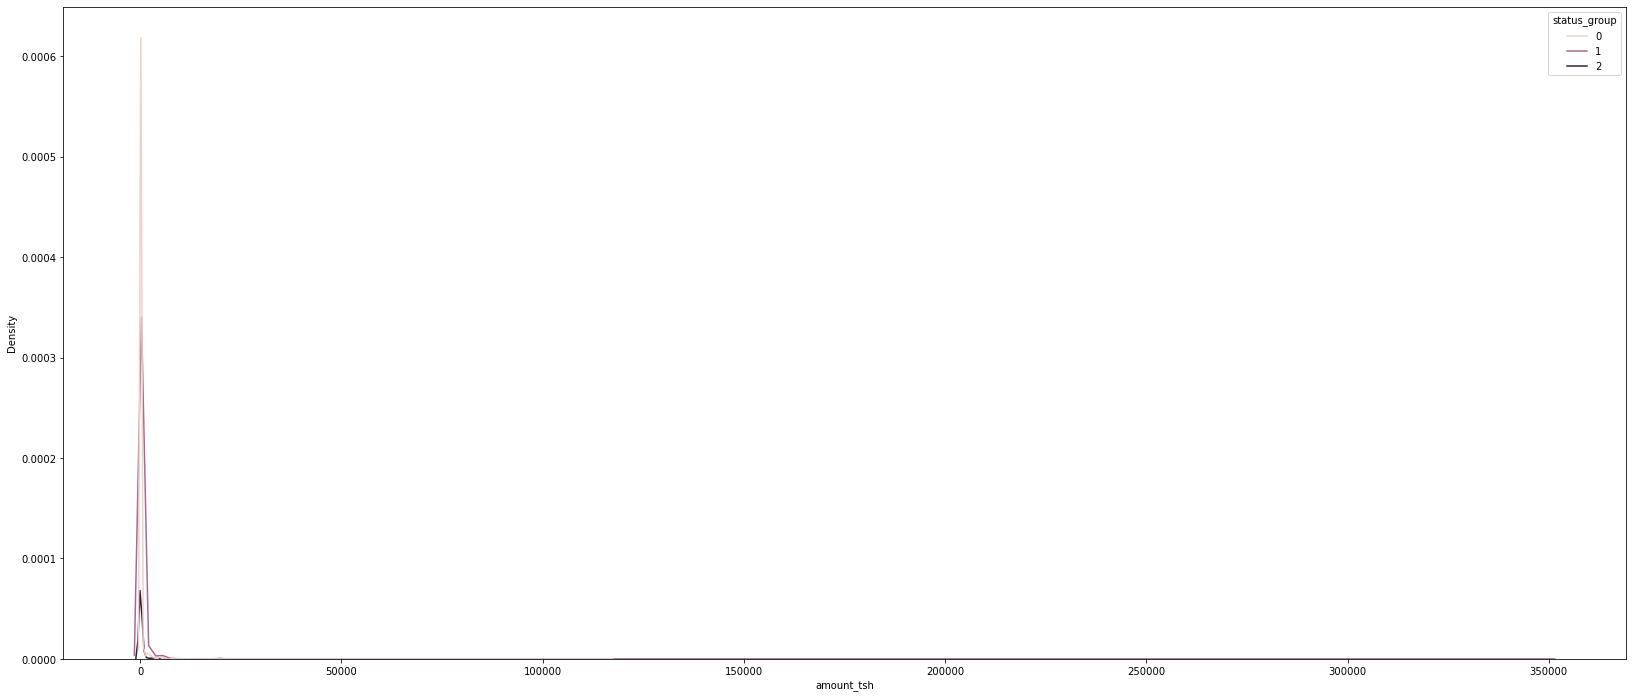

In [145]:
plt.figure(figsize=(28,12))
sns.kdeplot(data=df1, x='amount_tsh', hue="status_group", gridsize=200)

we will try replacing the zero values with mean value

In [11]:
df2 = df1.copy() #creating copy of dataset

In [12]:
df2.shape

(59400, 23)

In [148]:
df2['amount_tsh'].describe()

count     59400.000000
mean        317.650385
std        2997.574558
min           0.000000
25%           0.000000
50%           0.000000
75%          20.000000
max      350000.000000
Name: amount_tsh, dtype: float64

In [13]:
df2['amount_tsh'].replace(to_replace = 0 , value =1062.35, inplace=True)

In [14]:
df2['amount_tsh'].describe()  #checking after replacement of zero with mean

count     59400.000000
mean       1062.350581
std        2957.853024
min           0.200000
25%        1062.350000
50%        1062.350000
75%        1062.350000
max      350000.000000
Name: amount_tsh, dtype: float64

<AxesSubplot:xlabel='amount_tsh', ylabel='Density'>

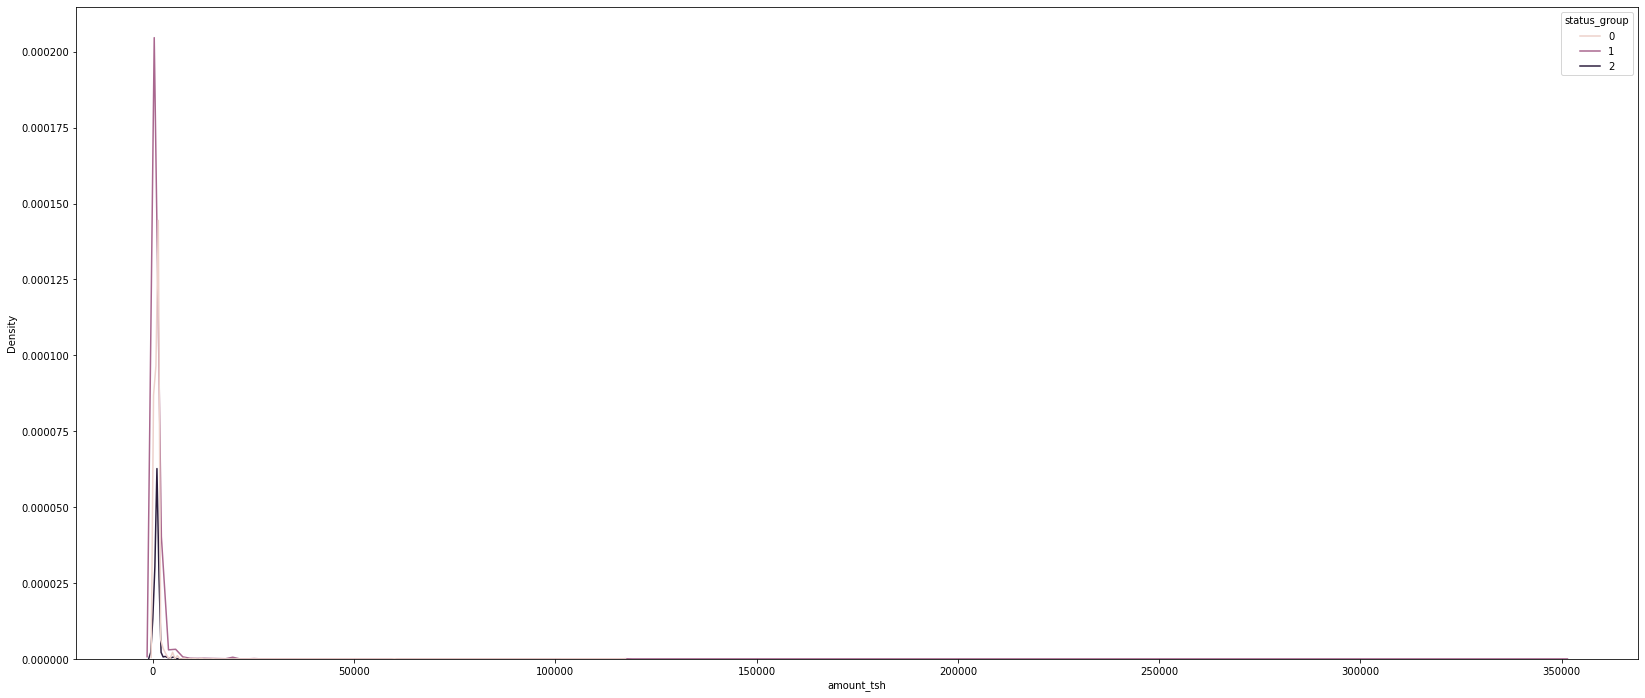

In [151]:
plt.figure(figsize=(28,12))
sns.kdeplot(data=df2, x='amount_tsh', hue="status_group", gridsize=200)

#### 4.4 Modeling with 'amount_tsh'

#### 4.4.1 Generating list of numerical and categorical values 

In [15]:
df2.columns

Index(['id', 'amount_tsh', 'funder', 'gps_height', 'installer', 'longitude',
       'latitude', 'basin', 'region', 'district_code', 'lga', 'population',
       'public_meeting', 'permit', 'extraction_type_group', 'management',
       'payment', 'water_quality', 'quantity', 'source', 'status_group',
       'operational_year', 'waterpoint_type'],
      dtype='object')

In [16]:
numerical_features = [feature for feature in df2.columns if df2[feature].dtype != 'O']
categorical_features = [feature for feature in df2.columns if df2[feature].dtype == 'O']

# print columns
print('We have {} numerical features : {}'.format(len(numerical_features), numerical_features))
print('\nWe have {} categorical features : {}'.format(len(categorical_features), categorical_features))

We have 11 numerical features : ['id', 'amount_tsh', 'gps_height', 'longitude', 'latitude', 'district_code', 'population', 'public_meeting', 'permit', 'status_group', 'operational_year']

We have 12 categorical features : ['funder', 'installer', 'basin', 'region', 'lga', 'extraction_type_group', 'management', 'payment', 'water_quality', 'quantity', 'source', 'waterpoint_type']


In [18]:
numerical_features = ['amount_tsh','gps_height','longitude', 'latitude', 'district_code','population','operational_year']

In [19]:
categorical_features = ['funder','installer','basin', 'region', 'lga','public_meeting','permit', 'extraction_type_group',
       'management', 'payment', 'water_quality', 'quantity', 'source','waterpoint_type']

In [20]:
len(categorical_features)

14

In [21]:
len(numerical_features)

7

In [22]:
df2.head(1)

,id,amount_tsh,funder,gps_height,installer,longitude,latitude,basin,region,district_code,...,permit,extraction_type_group,management,payment,water_quality,quantity,source,status_group,operational_year,waterpoint_type
0,69572,6000.0,other,1390,other,34.938093,-9.856322,Lake Nyasa,Iringa,5,...,0,gravity,vwc,pay annually,soft,enough,spring,1,12,communal standpipe


#### 4.4.2 Separating target column 'status_group' from other columns 

In [159]:
y=df2['status_group']
X = df2.drop(columns = ['status_group', 'id'])

In [160]:
X.shape

(59400, 21)

In [161]:
y.shape

(59400,)

#### 4.4.3 Splitting the data

In [162]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=35)

#### 4.4.4 Standardising the numerical features using RobustScaler

In [163]:
transformer = RobustScaler().fit(X_train[numerical_features])

In [164]:
transformer.transform(X_train[numerical_features])

array([[ 0.00000000e+00, -2.79210926e-01, -8.96727076e-01, ...,
         3.33333333e-01,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00, -2.79210926e-01, -6.00695420e-01, ...,
         0.00000000e+00,  0.00000000e+00,  2.22222222e-01],
       [ 0.00000000e+00, -2.64795144e-01,  1.11542716e+00, ...,
        -3.33333333e-01, -4.47779753e-01, -2.22222222e-01],
       ...,
       [ 0.00000000e+00, -2.79210926e-01, -1.07130384e+00, ...,
         9.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00, -2.79210926e-01, -2.13696508e-01, ...,
        -6.66666667e-01,  0.00000000e+00,  1.11111111e-01],
       [-1.05735000e+03,  5.72837633e-01,  6.02806549e-01, ...,
         6.66666667e-01, -1.27611012e+00, -1.11111111e-01]])

In [165]:
transformer.transform(X_test[numerical_features])

array([[ 0.00000000e+00, -2.79210926e-01, -8.56100409e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  5.52352049e-01, -1.06803837e-01, ...,
        -6.66666667e-01, -5.25090588e-01, -8.88888889e-01],
       [ 0.00000000e+00, -2.79210926e-01, -2.70020041e-01, ...,
         3.33333333e-01,  0.00000000e+00,  0.00000000e+00],
       ...,
       [-5.62350000e+02,  9.97723824e-01, -1.59183129e-01, ...,
         0.00000000e+00,  0.00000000e+00,  1.11111111e-01],
       [-5.62350000e+02, -6.37329287e-02,  4.63123027e-01, ...,
         3.33333333e-01, -1.23745471e+00, -8.88888889e-01],
       [ 0.00000000e+00, -2.79210926e-01, -3.37846948e-01, ...,
        -3.33333333e-01,  0.00000000e+00,  1.11111111e-01]])

In [166]:
X_train[numerical_features] = transformer.transform(X_train[numerical_features])

In [167]:
X_test[numerical_features] = transformer.transform(X_test[numerical_features])

In [168]:
X_train.head()

,amount_tsh,funder,gps_height,installer,longitude,latitude,basin,region,district_code,lga,...,public_meeting,permit,extraction_type_group,management,payment,water_quality,quantity,source,operational_year,waterpoint_type
51950,0.0,Hesawa,-0.279211,DWE,-0.896727,0.418023,Lake Tanganyika,Kagera,0.333333,Biharamulo,...,1,1,gravity,vwc,never pay,soft,seasonal,rainwater harvesting,0.000000,communal standpipe
33024,0.0,Rwssp,-0.279211,DWE,-0.600695,0.228799,Lake Victoria,Shinyanga,0.000000,Kahama,...,1,1,other,wug,unknown,milky,insufficient,shallow well,0.222222,other
33547,0.0,Undefined,-0.264795,Undefined,1.115427,-0.370306,Wami / Ruvu,Dar es Salaam,-0.333333,Ilala,...,1,0,submersible,parastatal,never pay,soft,enough,machine dbh,-0.222222,communal standpipe
1813,0.0,other,-0.279211,other,-0.559189,-0.116281,Lake Tanganyika,Tabora,0.666667,Sikonge,...,1,1,india mark ii,vwc,never pay,soft,dry,machine dbh,0.111111,hand pump
17664,0.0,Tcrs,0.756449,DWE,0.469989,0.453226,Internal,Arusha,1.000000,Longido,...,1,1,gravity,vwc,pay when scheme fails,soft,dry,river,-0.111111,communal standpipe


In [169]:
X_test.head()

,amount_tsh,funder,gps_height,installer,longitude,latitude,basin,region,district_code,lga,...,public_meeting,permit,extraction_type_group,management,payment,water_quality,quantity,source,operational_year,waterpoint_type
59379,0.00,other,-0.279211,other,-0.856100,0.613682,Lake Victoria,Kagera,0.000000,Muleba,...,1,1,gravity,vwc,never pay,soft,enough,spring,0.000000,communal standpipe
23853,0.00,other,0.552352,DWE,-0.106804,0.172762,Internal,Singida,-0.666667,Iramba,...,1,1,gravity,parastatal,never pay,soft,seasonal,rainwater harvesting,-0.888889,communal standpipe
4306,0.00,Undefined,-0.279211,Undefined,-0.270020,-0.830738,Lake Nyasa,Mbeya,0.333333,Rungwe,...,1,1,gravity,vwc,never pay,soft,enough,spring,0.000000,communal standpipe
11714,0.00,Hesawa,0.775417,HESAWA,-0.101200,0.586696,Lake Victoria,Mara,-0.333333,Serengeti,...,0,1,gravity,wug,never pay,soft,enough,spring,0.333333,communal standpipe
36791,-62.35,Danida,0.485584,other,0.164856,-1.087846,Ruvuma / Southern Coast,Ruvuma,0.333333,Songea Rural,...,0,1,india mark ii,vwc,pay monthly,soft,enough,shallow well,1.333333,hand pump


#### 4.4.5 Encoding of categorical features

In [171]:
import category_encoders as ce
transformer_te = ce.TargetEncoder().fit(X_train[categorical_features], y_train)

In [172]:
X_train[categorical_features] = transformer_te.transform(X_train[categorical_features])
X_test[categorical_features] = transformer_te.transform(X_test[categorical_features])

In [173]:
X_train.head()

,amount_tsh,funder,gps_height,installer,longitude,latitude,basin,region,district_code,lga,...,public_meeting,permit,extraction_type_group,management,payment,water_quality,quantity,source,operational_year,waterpoint_type
51950,0.0,0.628118,-0.279211,0.727951,-0.896727,0.418023,0.709981,0.693627,0.333333,0.772036,...,1,1,0.801130,0.641465,0.598014,0.718483,0.781402,0.881709,0.000000,0.778496
33024,0.0,0.740807,-0.279211,0.727951,-0.600695,0.228799,0.686842,0.815691,0.000000,0.549928,...,1,1,0.226949,0.800115,0.537454,0.562974,0.713554,0.604793,0.222222,0.222717
33547,0.0,0.752472,-0.264795,0.755051,1.115427,-0.370306,0.613160,0.571651,-0.333333,0.686076,...,1,0,0.618023,0.833333,0.598014,0.718483,0.794656,0.576823,-0.222222,0.778496
1813,0.0,0.715915,-0.279211,0.674986,-0.559189,-0.116281,0.709981,0.471591,0.666667,0.270833,...,1,1,0.667534,0.641465,0.598014,0.718483,0.038500,0.576823,0.111111,0.733453
17664,0.0,0.522541,0.756449,0.727951,0.469989,0.453226,0.721076,0.791061,1.000000,0.857143,...,1,1,0.801130,0.641465,0.764405,0.718483,0.038500,0.819604,-0.111111,0.778496


In [174]:
X_test.head()

,amount_tsh,funder,gps_height,installer,longitude,latitude,basin,region,district_code,lga,...,public_meeting,permit,extraction_type_group,management,payment,water_quality,quantity,source,operational_year,waterpoint_type
59379,0.00,0.715915,-0.279211,0.674986,-0.856100,0.613682,0.686842,0.693627,0.000000,0.492355,...,1,1,0.801130,0.641465,0.598014,0.718483,0.794656,0.774558,0.000000,0.778496
23853,0.00,0.715915,0.552352,0.727951,-0.106804,0.172762,0.721076,0.606509,-0.666667,0.786667,...,1,1,0.801130,0.833333,0.598014,0.718483,0.781402,0.881709,-0.888889,0.778496
4306,0.00,0.752472,-0.279211,0.755051,-0.270020,-0.830738,0.760453,0.720716,0.333333,0.911236,...,1,1,0.801130,0.641465,0.598014,0.718483,0.794656,0.774558,0.000000,0.778496
11714,0.00,0.628118,0.775417,0.630941,-0.101200,0.586696,0.686842,0.506305,-0.333333,0.663265,...,0,1,0.801130,0.800115,0.598014,0.718483,0.794656,0.774558,0.333333,0.778496
36791,-62.35,0.658088,0.485584,0.674986,0.164856,-1.087846,0.519412,0.686632,0.333333,0.713249,...,0,1,0.667534,0.641465,0.880207,0.718483,0.794656,0.604793,1.333333,0.733453


In [176]:
from sklearn.linear_model import LogisticRegression
clf_lr1 = LogisticRegression(class_weight = 'balanced', solver = 'lbfgs', random_state=30)
clf_lr1.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', random_state=30)

In [199]:
# making prediction on train set
y_pred_train = clf_lr1.predict(X_train)

# making predictions on test set
y_pred_test = clf_lr1.predict(X_test)

# printing the result
print("Accuracy:")
print("*"*50)
print("TRAIN:", accuracy_score(y_train, y_pred_train))
print("TEST:", accuracy_score(y_test, y_pred_test))


print("\nBalanced Accuracy:")
print("*"*50)
print("TRAIN:", balanced_accuracy_score(y_train, y_pred_train))
print("TEST:", balanced_accuracy_score(y_test, y_pred_test))

Accuracy:
**************************************************
TRAIN: 0.4858585858585859
TEST: 0.49107744107744106

Balanced Accuracy:
**************************************************
TRAIN: 0.47277359029364857
TEST: 0.47372617664030797


#### 4.5 Modeling without 'amount_tsh'

In [185]:
numerical_features1 = ['gps_height','longitude', 'latitude', 'district_code','population','operational_year']

In [180]:
df3 = df1.copy() #creating copy of dataset

In [181]:
y1=df3['status_group']
X1 = df3.drop(columns = ['status_group', 'id','amount_tsh'])

In [182]:
from sklearn.model_selection import train_test_split
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.2, random_state=35)

In [186]:
transformer1 = RobustScaler().fit(X_train1[numerical_features1])

In [188]:
X_train1[numerical_features1] = transformer1.transform(X_train1[numerical_features1])
X_test1[numerical_features1] = transformer1.transform(X_test1[numerical_features1])

In [189]:
import category_encoders as ce
transformer_te1 = ce.TargetEncoder().fit(X_train1[categorical_features], y_train1)

In [190]:
X_train1[categorical_features] = transformer_te1.transform(X_train1[categorical_features])
X_test1[categorical_features] = transformer_te1.transform(X_test1[categorical_features])

In [191]:
from sklearn.linear_model import LogisticRegression
clf_lr2 = LogisticRegression(class_weight = 'balanced', solver = 'lbfgs', random_state=30)
clf_lr2.fit(X_train1, y_train1)

LogisticRegression(class_weight='balanced', random_state=30)

In [200]:
# making prediction on train set
y_pred_train1 = clf_lr2.predict(X_train1)

# making predictions on test set
y_pred_test1 = clf_lr2.predict(X_test1)

# printing the result
print("Accuracy:")
print("*"*50)
print("TRAIN:", accuracy_score(y_train1, y_pred_train1))
print("TEST:", accuracy_score(y_test1, y_pred_test1))


print("\nBalanced Accuracy:")
print("*"*50)
print("TRAIN:", balanced_accuracy_score(y_train1, y_pred_train1))
print("TEST:", balanced_accuracy_score(y_test1, y_pred_test1))

Accuracy:
**************************************************
TRAIN: 0.6254208754208754
TEST: 0.6262626262626263

Balanced Accuracy:
**************************************************
TRAIN: 0.607809164357186
TEST: 0.6043859306810534


From above result it is understood that accuracy has improved after removing the feature 'amount_tsh'. Hence we conclude that it is not adding any value in prediction and hence should be removed.